# Imports

In [1]:
from __future__ import print_function # Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import decomposition # Sklearn user for plotting reasons
import sklearn as skl 

import tensorflow.keras as k # Math and machine learning libraries
import tensorflow as tf
import numpy as np
import math


import datetime as dt
import math
import time
import random

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Data Visualization

In [2]:
# First we load our dataset, I'm going to use a a simple dataset like mnist thats well documented because I'm going to be implementing a different typeo model.
((train_x, train_y), (test_x, test_y)) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

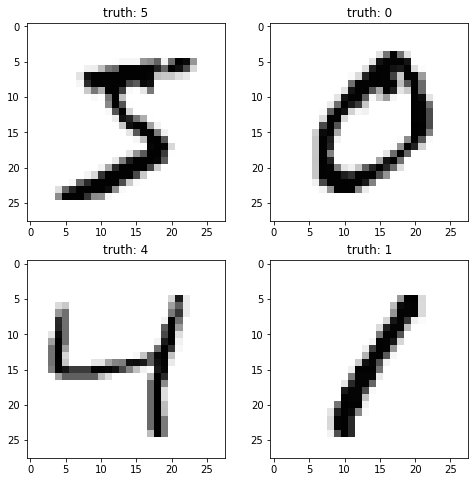

In [3]:
# First we'll plot a few of the images to get a feel of what they look like
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(train_x[i], cmap='Greys')
    plt.title(f'truth: {train_y[i]}')
# The data is composed of images of handwritten digits that are labled with
# the digit that it is supposed to be identified as.

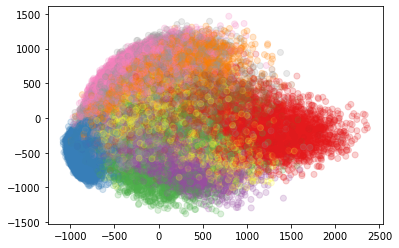

In [4]:
# Next we can do a princable component analysis  in order to
# see how the data is related to other points.
pca = decomposition.PCA(n_components=2)
view = pca.fit_transform(np.array(train_x).reshape(60000, 784))
plt.scatter(view[:,0], view[:,1], c=train_y, alpha=0.2, cmap='Set1')

I expect this dataset to be clean as it is the mnist dataset, so I'm not going to do much preprocessing.

# Building a Neural Network 
A simple neural network that can identify numbers to get a base line performance

In [5]:
# This model is basically just linear regression as there are no 
# intermediate layers between input and output
model = k.Sequential()
model.add(k.Input(shape=(784,)))
model.add(k.layers.Dense(10, activation='softmax'))

model.compile(optimizer="Adam", loss="mse", metrics=["accuracy"])
model.summary()

history = model.fit(
    np.array(train_x).reshape(60000, 784) / 255, 
    k.utils.to_categorical(np.array(train_y)), 
    batch_size=128, 
    epochs=10)
results = model.evaluate(
    np.array(test_x).reshape(10000, 784) / 255, 
    k.utils.to_categorical(np.array(test_y)), 
    batch_size=128)
print("test loss, test acc:", results)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 1s 727us/step - loss: 0.0427 - accuracy: 0.7351
Epoch 2/10
469/469 [==============================] - 0s 731us/step - loss: 0.0159 - accuracy: 0.9048
Epoch 3/10
469/469 [==============================] - 0s 724us/step - loss: 0.0137 - accuracy: 0.9154
Epoch 4/10
469/469 [==============================] - 0s 746us/step - loss: 0.0128 - accuracy: 0.9196
Epoch 5/10
469/469 [==============================] - 0s 719us/step - loss: 0.0120 - accuracy: 0.9235
Epoch 6/10
469/469 [==============================] - 0s 721us/step - loss: 0.0118 - accuracy: 0.9257
Epoch 7/10
469/469 [================

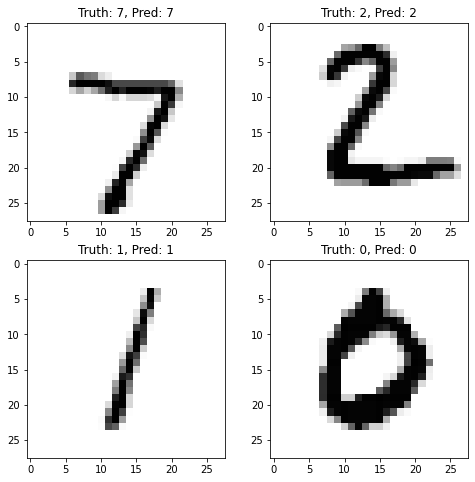

In [6]:
pred = [np.argmax(r) for r in model.predict(np.array(test_x[0:4]).reshape(4, 784))]
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(test_x[i], cmap='Greys')
    plt.title(f'Truth: {test_y[i]}, Pred: {pred[i]}')

In [7]:
# This model is probably a little too big and would likely over
# intermediate layers between input and output
model = k.Sequential()
model.add(k.Input(shape=(784,)))
model.add(k.layers.Dense(784, activation='relu'))
model.add(k.layers.Dense(10, activation='softmax'))

model.compile(optimizer="Adam", loss="mse", metrics=["accuracy"])
model.summary()

history = model.fit(
    np.array(train_x).reshape(60000, 784) / 255, 
    k.utils.to_categorical(np.array(train_y)), 
    batch_size=128, 
    epochs=10)
results = model.evaluate(
    np.array(test_x).reshape(10000, 784) / 255, 
    k.utils.to_categorical(np.array(test_y)), 
    batch_size=128)
print("test loss, test acc:", results)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0190 - accuracy: 0.8745
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0054 - accuracy: 0.9666
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0035 - accuracy: 0.9790
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0026 - accuracy: 0.9843
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0019 - accuracy: 0.9888
Epoch 6/10

First i want to build out a classes for the neurons, layers and networks

In [174]:
class Neuron:
    def __init__(self, num, leak, lr):
        # a unique identifier
        self.num = num
        # When the neuron will fire
        self.action_potential = 105.0
        # The membrane potential when it was last checked
        self.membrane_potential = 0
        # references to neurons that will increase this one's potential
        self.incomming_connections = {}
        # references to neurons that will be increased by this one
        self.outgoing_connections = []
        # resting potential
        self.resting_potential = 0
        # leak ammount
        self.leak = leak # 1
        # last fire
        self.last_fire = dt.datetime.now()
        # how long the neron has to physically wait befor it can fire again.
        self.fire_rate = dt.timedelta(microseconds=500)
        # expected output
        self.expected_output = None
        self.update_weights = True
        self.lr = lr # 0.1
    
    def set_weight_update(self, b):
        self.update_weights = b

    def set_outputs(self, output):
        self.expected_output = output
        
    
    def add_recipient(self, neuron):
        """
        Add a connection to a new neuron.
        """
        self.outgoing_connections.append(neuron)
    
    def l(self):
        """
        A function that will cause a constant leakage of membrane potential.
        This keeps the neuron near "equilibrium".
        """
        if self.membrane_potential < self.resting_potential:
            # If we are below the resting potential we rise to it.
            self.membrane_potential += self.leak
        else:
            # If we are above the resting potential we lower to it.
            self.membrane_potential -= self.leak

    def receive_input(self, amount):
        self.membrane_potential += amount

        
    def attempt_fire(self):
        self.l()
        if self.membrane_potential > self.action_potential:
            return self.fire()
        return []

    def fire(self):
        self.last_fire = dt.datetime.now()
        self.membrane_potential = -10
        return [c.receive_fire(self.num) for c in self.outgoing_connections]  
        
    
    def receive_fire(self, neuron):
        """To be used with multiprocessing """
        weight = self.incomming_connections.get(neuron)
        if weight is not None:
            self.membrane_potential += weight
        else:
            # setting initial weight
            self.incomming_connections[neuron] = random.random() * 10 + 10
            self.membrane_potential += self.incomming_connections[neuron]
        if self.membrane_potential >= self.action_potential and self.membrane_potential - self.incomming_connections[neuron] >= self.action_potential and self.update_weights == True:
            self.incomming_connections[neuron] -= self.lr
            return None
            
        if self.membrane_potential >= self.action_potential:
            if self.expected_output != None:
                if self.expected_output == 0 and self.update_weights == True:
                    self.incomming_connections[neuron] -= self.lr * 2
            if self.update_weights == True:
                self.incomming_connections[neuron] += self.lr
            return None
        if self.update_weights == True:
            self.incomming_connections[neuron] -= self.lr
        return None

In [175]:
class Layer:
    def __init__(self, size, leak, lr):
        self.neurons = [Neuron(i, leak, lr) for i in range(size)]
    
    def attempt_fire(self):
        firing = []
        for neuron in self.neurons:
            fs = neuron.attempt_fire()
            firing.append(1 if len(fs) > 0 else 0)
        return firing
    
    def fire(self):
        firing = []
        for neuron in self.neurons:
            fs = neuron.attempt_fire()
            firing.append(1 if len(fs) > 0 else 0)
        return firing
    
    def receive_inputs(self, inputs):
        for i in range(len(inputs)):
            self.neurons[i].receive_input(inputs[i])


    def set_training_outputs(self, outputs):
        for i in range(len(outputs)):
            self.neurons[i].set_outputs(outputs[i])

    def set_update(self, b):
        for neuron in self.neurons:
            neuron.set_weight_update(b)

In [178]:
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped
class Network:
    def __init__(self, lr, lrnr):
        self.layers = []
        self.tn = Neuron(100, lr, lrnr)
    
    def add(self, layer):
        self.layers.append(layer)
    
    def full_connect(self):
        for i in range(len(self.layers)):
            for neuron in self.layers[i].neurons:
                if i + 1 < len(self.layers):
                    for r_neuron in self.layers[i + 1].neurons:
                        neuron.add_recipient(r_neuron)
                else:
                    neuron.add_recipient(self.tn)
  
    def train(self, full_inputs, full_outputs, time_per_image):
        results = []
        if len(full_inputs) != len(full_outputs):
            print('you have done something wrong!')
            return None
        for layer in self.layers:
            layer.set_update(True)
        for i in range(len(full_inputs)):
            output_for_image = [0 for _ in range(len(self.layers[-1].neurons))]
            self.layers[-1].set_training_outputs(full_outputs[i])
            for _ in range(time_per_image):
                self.layers[0].receive_inputs(full_inputs[i])
                for j in range(0, len(self.layers) - 1):
                    self.layers[j].attempt_fire()
                output = self.layers[-1].attempt_fire()
                for io in range(len(output)):
                    output_for_image[io] += output[io]
                results.append([mm / sum(output_for_image) if sum(output_for_image) != 0 else 0 for mm in output_for_image])
        return results
    
    def predict(self, full_inputs, time_per_image):
        results = []
        for layer in self.layers:
            layer.set_update(False)
        for i in range(len(full_inputs)):
            output_for_image = [0 for _ in range(len(self.layers[-1].neurons))]
            for _ in range(time_per_image):
                self.layers[0].receive_inputs(full_inputs[i])
                for j in range(0, len(self.layers) - 1):
                    self.layers[j].attempt_fire()
                output = self.layers[-1].attempt_fire()
                for io in range(len(output)):
                    output_for_image[io] += output[io]
            results.append([mm / sum(output_for_image) if sum(output_for_image) != 0 else 0 for mm in output_for_image])
        return results
            

        
    def receive_inputs(self, inputs):
        if len(inputs) != len(self.layers[0]):
            print('input len != len of first layer')
        self.layers[0].receive_input(inputs)

    def set_training_outputs(self, desired_outputs):
        if len(desired_outputs) != len(self.layers[-1]):
            print('input len != len of first layer')
        self.layers[0].set_training_outputs(set_training_outputs)
        
    
    def sparse_connect(self, amount):
        for i in range(len(self.layers)):
            for neuron in self.layers[i].neurons:
                if i + 1 < len(self.layers):
                    for r_neuron in self.layers[i + 1].neurons:
                        if random.random() < amount:
                            neuron.add_recipient(r_neuron)
                else:
                    neuron.add_recipient(self.tn)
        

Next we can run hyper parameter tuning

In [183]:
leak_rate = [0.5, 0.25, 0]
learning_rate = [0.25, 0.125, 0.0625, 0.005]
connectivity = [1, 0.75, 0.5]
ammount_of_time = [10, 15, 20]

for leak_r in leak_rate:
    for learn_r in learning_rate:
        for c in connectivity:
            for t in ammount_of_time:
                model = Network(leak_r, learn_r)
                model.add(Layer(784, leak_r, learn_r))
                model.add(Layer(10, leak_r, leak_r))
                model.sparse_connect(c)
                model.train(np.array(train_x[0:1000]).reshape(1000, 784) / 255, k.utils.to_categorical(np.array(train_y[0:1000])), t)
                prediction = model.predict(np.array(test_x[0:100]).reshape(100, 784) / 255, 100)
                print(f'leak rate:{leak_r}, learn rate:{learn_r}, conectivity, {c}, time {t}, MSE: {skl.metrics.mean_squared_error(k.utils.to_categorical(np.array(test_y[0:100])), prediction)}')
                
                
    

leak rate:0.5, learn rate:0.25, conectivity, 1, time 10, MSE: 0.106602499595059
leak rate:0.5, learn rate:0.25, conectivity, 1, time 15, MSE: 0.10747012611013027
leak rate:0.5, learn rate:0.25, conectivity, 1, time 20, MSE: 0.10589653100856941
leak rate:0.5, learn rate:0.25, conectivity, 0.75, time 10, MSE: 0.11347179507499632
leak rate:0.5, learn rate:0.25, conectivity, 0.75, time 15, MSE: 0.10811953223917872
leak rate:0.5, learn rate:0.25, conectivity, 0.75, time 20, MSE: 0.10541638231799713
leak rate:0.5, learn rate:0.25, conectivity, 0.5, time 10, MSE: 0.10909522707231038
leak rate:0.5, learn rate:0.25, conectivity, 0.5, time 15, MSE: 0.10923150793650793
leak rate:0.5, learn rate:0.25, conectivity, 0.5, time 20, MSE: 0.10698596083403775
leak rate:0.5, learn rate:0.125, conectivity, 1, time 10, MSE: 0.10761548918635308
leak rate:0.5, learn rate:0.125, conectivity, 1, time 15, MSE: 0.10539213214357931
leak rate:0.5, learn rate:0.125, conectivity, 1, time 20, MSE: 0.1035417455737083
l

leak rate:0, learn rate:0.0625, conectivity, 0.5, time 20, MSE: 0.09034777332092425
leak rate:0, learn rate:0.005, conectivity, 1, time 10, MSE: 0.09009642988509788
leak rate:0, learn rate:0.005, conectivity, 1, time 15, MSE: 0.08991297444176714
leak rate:0, learn rate:0.005, conectivity, 1, time 20, MSE: 0.09013292800188025
leak rate:0, learn rate:0.005, conectivity, 0.75, time 10, MSE: 0.09020398444905983
leak rate:0, learn rate:0.005, conectivity, 0.75, time 15, MSE: 0.09008332620154515
leak rate:0, learn rate:0.005, conectivity, 0.75, time 20, MSE: 0.09020512170110424
leak rate:0, learn rate:0.005, conectivity, 0.5, time 10, MSE: 0.09104576282559954
leak rate:0, learn rate:0.005, conectivity, 0.5, time 15, MSE: 0.09031374406240238
leak rate:0, learn rate:0.005, conectivity, 0.5, time 20, MSE: 0.0903457763512488


Then lets fully train a model that uses the best settings

In [ ]:
model = Network(0, 0.125)
model.add(Layer(784, 0, 0.125))
model.add(Layer(10, 0, 0.1))
model.sparse_connect(1)
for _ in range(1): # Epochs
    model.train(np.array(train_x).reshape(60000, 784) / 255, k.utils.to_categorical(np.array(train_y)), 20)

In [ ]:
prediction = model.predict(np.array(test_x).reshape(10000, 784) / 255, 100)
skl.metrics.mean_squared_error(k.utils.to_categorical(np.array(test_y)), prediction)

In [ ]:
pred = [np.argmax(prediction[i]) for i in range(4)]
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(test_x[i], cmap='Greys')
    plt.title(f'Truth: {test_y[i]}, Pred: {pred[i]}')

This model obviously can't compete with a typical neural network because it learning algorithm is less efficient right now. I kind of implemented a version of spike time dependant platicity, but that didn't turn out so well. Its also super slow to train and predict because we have to manually  fire every neuron to represent a time step, I had implemented a way for this to be better by utilising the multiprocessing module to fire neurons, but it turns out that you can't picklize functions so I ran into an issue there. 

This is very much a brute force implementation and in python no less so it is incredibly slow. I hope to spend more time optimizing it in the future and finding a work around for using mutiprocesssing to fire the neurons, which should significantly speed up performance.